In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as np
import jax.experimental.stax as stax
import jax.experimental.optimizers as optimizers
from IMNN.experimental.jax.utils import value_and_jacrev
import math
import itertools
import matplotlib.pyplot as plt
from IMNN.experimental.jax.imnn import SimulatorIMNN
from IMNN.experimental.jax.imnn import AggregatedSimulatorIMNN
from IMNN.experimental.jax.imnn import GradientIMNN
from IMNN.experimental.jax.imnn import NumericalGradientIMNN
from IMNN.experimental.jax.lfi import GaussianApproximation
from IMNN.experimental.jax.lfi import ApproximateBayesianComputation
from functools import partial
rng = jax.random.PRNGKey(0)

# Simulator in JAX

In [3]:
θ_fid = np.array([0., 1.])
n_params = 2
input_shape = (10,)
simulator_args = {"input shape": input_shape}

In [4]:
def simulator(rng, θ, simulator_args=simulator_args):
    μ, Σ = θ
    def fn(key, μ, Σ):
        return μ + np.sqrt(Σ) * jax.random.normal(key, shape=simulator_args["input shape"])
    if μ.shape == Σ.shape:
        if len(μ.shape) == 0:
            return fn(rng, μ, Σ)
        else:
            keys = jax.random.split(rng, num=μ.shape[0]+1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(lambda key, μ, Σ : simulator(key, (μ, Σ), simulator_args=simulator_args))(keys, μ, Σ)
    else:
        if len(μ.shape) > 0:
            keys = jax.random.split(rng, num=μ.shape[0]+1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(lambda key, μ : simulator(key, (μ, Σ), simulator_args=simulator_args))(keys, μ)
        elif len(Σ.shape) > 0:
            keys = jax.random.split(rng, num=Σ.shape[0])
            return jax.vmap(lambda key, Σ : simulator(key, (μ, Σ), simulator_args=simulator_args))(keys, Σ)

In [5]:
def simulator_gradient(rng, θ, simulator_args=simulator_args):
    return value_and_jacrev(simulator, argnums=1)(rng, θ, simulator_args=simulator_args)

In [6]:
μs = [np.zeros(()), np.zeros((1,)), np.zeros((2,)), np.zeros((1, 1)), np.zeros((1, 2)), np.zeros((2, 1)), np.zeros((2, 2)), np.zeros((1, 2, 3)), np.zeros((2, 1, 3)), np.zeros((3, 2, 1))] 
Σs = [np.ones(()), np.ones((1,)), np.ones((2,)), np.ones((1, 1)), np.ones((1, 2)), np.ones((2, 1)), np.ones((2, 2)), np.ones((1, 2, 3)), np.ones((2, 1, 3)), np.ones((3, 2, 1))]
for θ in itertools.product(μs[:2], Σs[:2]):
    simulation = simulator(rng, θ, simulator_args=simulator_args)
    print(θ[0].shape, θ[1].shape, simulation.shape)

() () (10,)
() (1,) (1, 10)
(1,) () (1, 10)
(1,) (1,) (1, 10)


# Data for ABC example

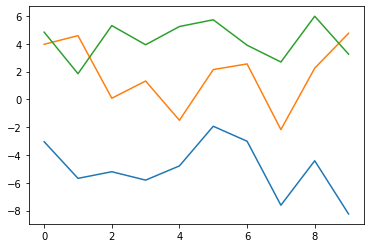

In [7]:
rng, key = jax.random.split(rng)
target_data = simulator(key, (np.array([-5., 2., 4.]), np.array([2., 5., 1.])), simulator_args=simulator_args)
plt.plot(target_data.T);

In [8]:
class uniform:
    def __init__(self, low, high):
        self.low = np.array(low)
        self.high = np.array(high)
        self.event_shape = [[] for i in range(self.low.shape[0])]
        
    def sample(self, n=None, seed=None):
        if n is None:
            n = 1
        keys = jax.random.split(key, num=len(self.event_shape))
        return [jax.random.uniform(keys[i], shape=(n,), minval=self.low[i], maxval=self.high[i]) for i in range(len(self.event_shape))]

prior = uniform([-10., 0.], [10., 10.])

# Model in STAX

In [9]:
n_summaries = 5
n_s = 1000
n_d = 1000
λ = 10.
ϵ = 0.1

In [10]:
model = stax.serial(
    stax.Dense(128),
    stax.LeakyRelu,
    stax.Dense(128),
    stax.LeakyRelu,
    stax.Dense(128),
    stax.LeakyRelu,
    stax.Dense(n_summaries))

In [11]:
optimiser = optimizers.adam(step_size=1e-3)

# Random seeds for IMNN

In [12]:
rng, initial_model_key = jax.random.split(rng)
rng, fitting_key = jax.random.split(rng)

# Random seeds for ABC

In [13]:
rng, abc_key = jax.random.split(rng)

# Simulations on the fly

### Initialise IMNN

In [14]:
simulator_imnn = SimulatorIMNN(
    n_s=n_s, n_d=n_d, n_summaries=n_summaries, input_shape=input_shape, 
    θ_fid=θ_fid, key=initial_model_key, model=model, optimiser=optimiser,                         
    simulator=lambda rng, θ: simulator(rng, θ, simulator_args=simulator_args))

#### Fit

In [15]:
simulator_imnn.fit(λ=λ, ϵ=ϵ, rng=fitting_key)

no available validation data. setting statistics with training set


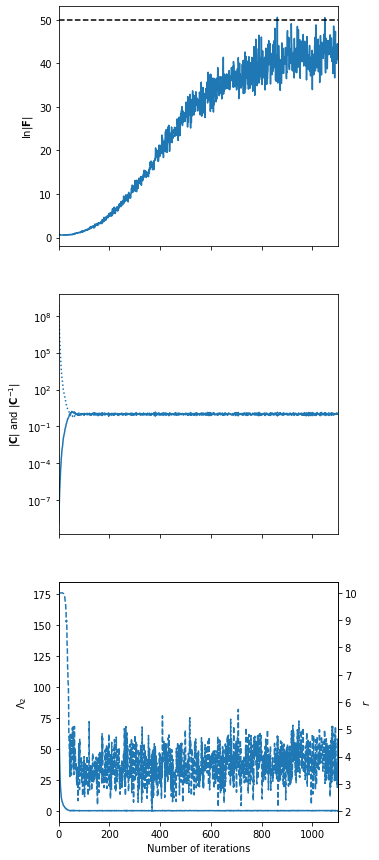

In [16]:
simulator_imnn.training_plot(expected_detF=50);

#### ABC

In [17]:
simulator_target_summaries = simulator_imnn.get_estimate(target_data)

In [18]:
simulator_ga = GaussianApproximation(
    simulator_target_summaries, simulator_imnn.invC, prior)

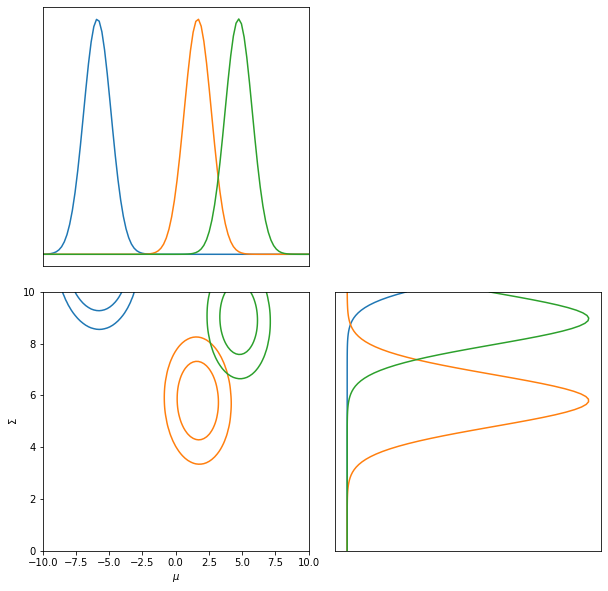

In [19]:
simulator_ga.marginal_plot(labels=[r"$\mu$", r"$\Sigma$"]);

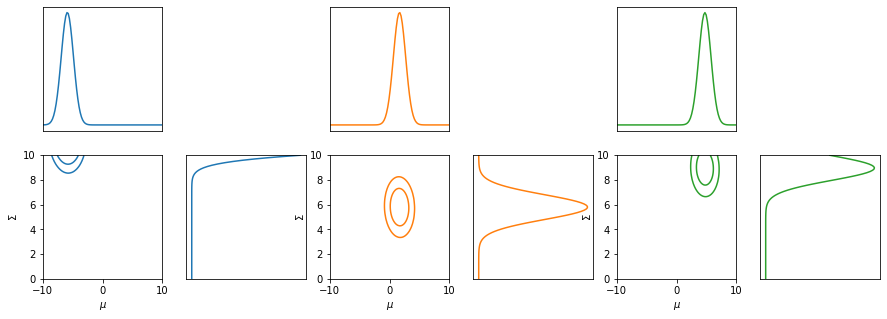

In [20]:
fig, ax = plt.subplots(2, 6, figsize=(15, 5))
simulator_ga.marginal_plot(ax=ax[:, :2], labels=[r"$\mu$", r"$\Sigma$"], target=0, format=True);
simulator_ga.marginal_plot(ax=ax[:, 2:4], labels=[r"$\mu$", r"$\Sigma$"], target=1, format=True);
simulator_ga.marginal_plot(ax=ax[:, 4:], labels=[r"$\mu$", r"$\Sigma$"], target=2, format=True);

In [21]:
simulator_abc = ApproximateBayesianComputation(
    target_data, prior, simulator, simulator_imnn.get_estimate, F=simulator_imnn.F, gridsize=50)

In [ ]:
simulator_abc(rng=abc_key, n_samples=int(1e6), min_accepted=1000, max_iterations=1000, ϵ=0.1, smoothing=1);

In [ ]:
ax = simulator_ga.marginal_plot(labels=[r"$\mu$", r"$\Sigma$"])
simulator_abc.marginal_plot(ax=ax, linestyle="dashed")
simulator_abc.scatter_plot(ax=ax, linestyle="dashed");

In [ ]:
fig, ax = plt.subplots(2, 6, figsize=(15, 5))
simulator_ga.marginal_plot(ax=ax[:, :2], labels=[r"$\mu$", r"$\Sigma$"], target=0, format=True);
simulator_abc.marginal_plot(ax=ax[:, :2], linestyle="dashed", target=0);
simulator_abc.scatter_plot(ax=ax[:, :2], linestyle="dotted", target=0, s=0.1);
simulator_ga.marginal_plot(ax=ax[:, 2:4], labels=[r"$\mu$", r"$\Sigma$"], target=1, format=True);
simulator_abc.marginal_plot(ax=ax[:, 2:4], linestyle="dashed", target=1);
simulator_abc.scatter_plot(ax=ax[:, 2:4], linestyle="dotted", target=1, s=0.1);
simulator_ga.marginal_plot(ax=ax[:, 4:], labels=[r"$\mu$", r"$\Sigma$"], target=2, format=True);
simulator_abc.marginal_plot(ax=ax[:, 4:], linestyle="dashed", target=2);
simulator_abc.scatter_plot(ax=ax[:, 4:], linestyle="dotted", target=2, s=0.1);

In [ ]:
simulator_abc.scatter_summaries(labels=["Estimate 1", "Estimate 2"]);

In [ ]:
fig, ax = plt.subplots(2, 6, figsize=(15, 5))
simulator_abc.scatter_summaries(ax=ax[:, :2], labels=["Estimate 1", "Estimate 2"], s=1, target=0, format=True);
simulator_abc.scatter_summaries(ax=ax[:, 2:4], labels=["Estimate 1", "Estimate 2"], s=1, target=1, format=True);
simulator_abc.scatter_summaries(ax=ax[:, 4:], labels=["Estimate 1", "Estimate 2"], s=1, target=2, format=True);

# Aggregated training

### Initialise IMNN

In [16]:
aggregated_simulator_imnn = AggregatedSimulatorIMNN(
    n_s=n_s, n_d=n_d, n_summaries=n_summaries, input_shape=input_shape, 
    θ_fid=θ_fid, key=initial_model_key, model=model, optimiser=optimiser, 
    simulator=lambda rng, θ: simulator(rng, θ, simulator_args=simulator_args),
    devices=jax.devices(), n_per_device=500)

#### Fit

In [17]:
aggregated_simulator_imnn.fit(λ=λ, ϵ=ϵ, rng=fitting_key)

no available validation data. setting statistics with training set


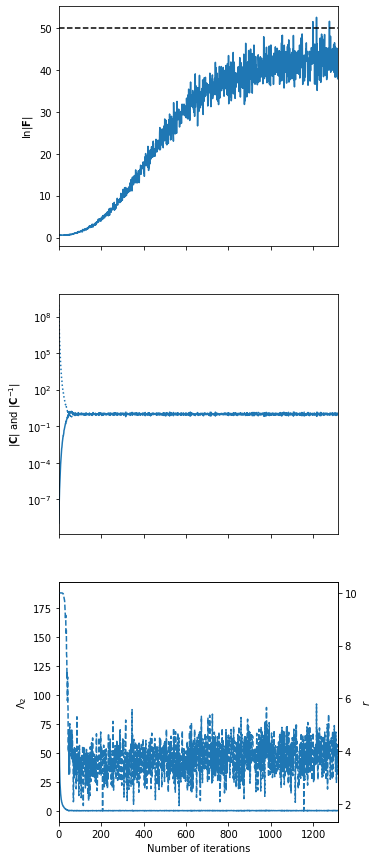

In [18]:
aggregated_simulator_imnn.training_plot(expected_detF=50);

#### ABC

In [17]:
simulator_target_summaries = simulator_imnn.get_estimate(target_data)

In [18]:
simulator_ga = GaussianApproximation(simulator_target_summaries, simulator_imnn.invC, prior)

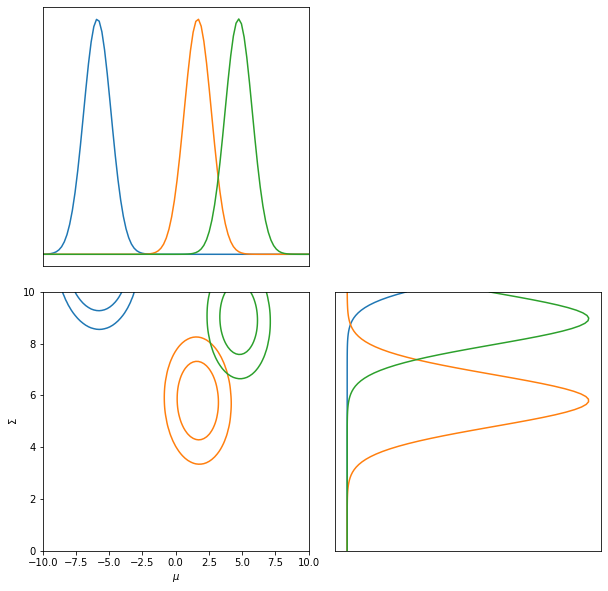

In [19]:
simulator_ga.marginal_plot(labels=[r"$\mu$", r"$\Sigma$"]);

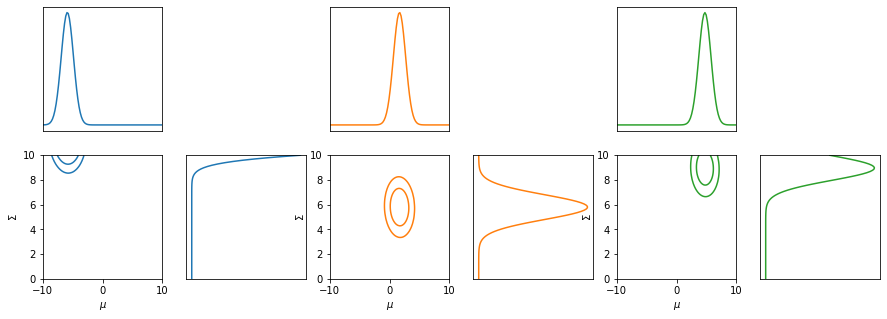

In [20]:
fig, ax = plt.subplots(2, 6, figsize=(15, 5))
simulator_ga.marginal_plot(ax=ax[:, :2], labels=[r"$\mu$", r"$\Sigma$"], target=0, format=True);
simulator_ga.marginal_plot(ax=ax[:, 2:4], labels=[r"$\mu$", r"$\Sigma$"], target=1, format=True);
simulator_ga.marginal_plot(ax=ax[:, 4:], labels=[r"$\mu$", r"$\Sigma$"], target=2, format=True);

In [21]:
simulator_abc = ApproximateBayesianComputation(target_data, prior, simulator, simulator_imnn.get_estimate, F=simulator_imnn.F, gridsize=50)

In [ ]:
simulator_abc(rng=abc_key, n_samples=int(1e6), min_accepted=1000, max_iterations=1000, ϵ=0.1, smoothing=1);

In [ ]:
ax = simulator_ga.marginal_plot(labels=[r"$\mu$", r"$\Sigma$"])
simulator_abc.marginal_plot(ax=ax, linestyle="dashed")
simulator_abc.scatter_plot(ax=ax, linestyle="dashed");

In [ ]:
fig, ax = plt.subplots(2, 6, figsize=(15, 5))
simulator_ga.marginal_plot(ax=ax[:, :2], labels=[r"$\mu$", r"$\Sigma$"], target=0, format=True);
simulator_abc.marginal_plot(ax=ax[:, :2], linestyle="dashed", target=0);
simulator_abc.scatter_plot(ax=ax[:, :2], linestyle="dotted", target=0, s=0.1);
simulator_ga.marginal_plot(ax=ax[:, 2:4], labels=[r"$\mu$", r"$\Sigma$"], target=1, format=True);
simulator_abc.marginal_plot(ax=ax[:, 2:4], linestyle="dashed", target=1);
simulator_abc.scatter_plot(ax=ax[:, 2:4], linestyle="dotted", target=1, s=0.1);
simulator_ga.marginal_plot(ax=ax[:, 4:], labels=[r"$\mu$", r"$\Sigma$"], target=2, format=True);
simulator_abc.marginal_plot(ax=ax[:, 4:], linestyle="dashed", target=2);
simulator_abc.scatter_plot(ax=ax[:, 4:], linestyle="dotted", target=2, s=0.1);

In [ ]:
simulator_abc.scatter_summaries(labels=["Estimate 1", "Estimate 2"]);

In [ ]:
fig, ax = plt.subplots(2, 6, figsize=(15, 5))
simulator_abc.scatter_summaries(ax=ax[:, :2], labels=["Estimate 1", "Estimate 2"], s=1, target=0, format=True);
simulator_abc.scatter_summaries(ax=ax[:, 2:4], labels=["Estimate 1", "Estimate 2"], s=1, target=1, format=True);
simulator_abc.scatter_summaries(ax=ax[:, 4:], labels=["Estimate 1", "Estimate 2"], s=1, target=2, format=True);

# Precomputed simulations

In [28]:
def get_simulations(rng, n_s, θ, simulator_args=simulator_args):
    def get_simulator(key):
        return simulator(key, θ, simulator_args=simulator_args)
    keys = jax.random.split(rng, num=n_s)
    return jax.vmap(get_simulator)(np.array(keys))

def get_simulation_gradients(rng, n_s, n_d, θ, simulator_args=simulator_args):
    def get_batch_gradient(key):
        return simulator_gradient(key, θ, simulator_args=simulator_args)
    keys = jax.random.split(rng, num=n_s)
    return jax.vmap(get_batch_gradient)(np.array(keys)[:n_d])

In [29]:
rng, *training_keys = jax.random.split(rng, num=1+n_s)

In [30]:
fiducial, derivative = jax.vmap(partial(simulator_gradient, θ=θ_fid, simulator_args=simulator_args))(np.array(training_keys))
fiducial.shape, derivative.shape

((1000, 10), (1000, 10, 2))

In [31]:
gradient_no_validation_imnn = GradientIMNN(n_s=n_s, n_d=n_d, n_summaries=n_summaries, input_shape=input_shape, 
                                           θ_fid=θ_fid, key=initial_model_key, model=model, optimiser=optimiser, 
                                           fiducial=fiducial, derivative=derivative)

In [32]:
gradient_no_validation_imnn.fit(λ=λ, α=α, rng=fitting_key)

no available validation data. setting statistics with training set


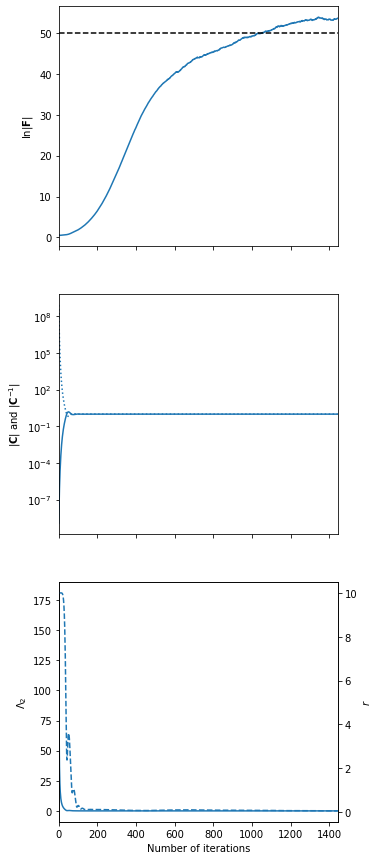

In [33]:
gradient_no_validation_imnn.training_plot(expected_detF=50);

#### ABC

In [34]:
gradient_no_validation_target_summaries = gradient_no_validation_imnn.get_estimate(target_data)

In [35]:
gradient_no_validation_ga = GaussianApproximation(gradient_no_validation_target_summaries, gradient_no_validation_imnn.invC, prior)

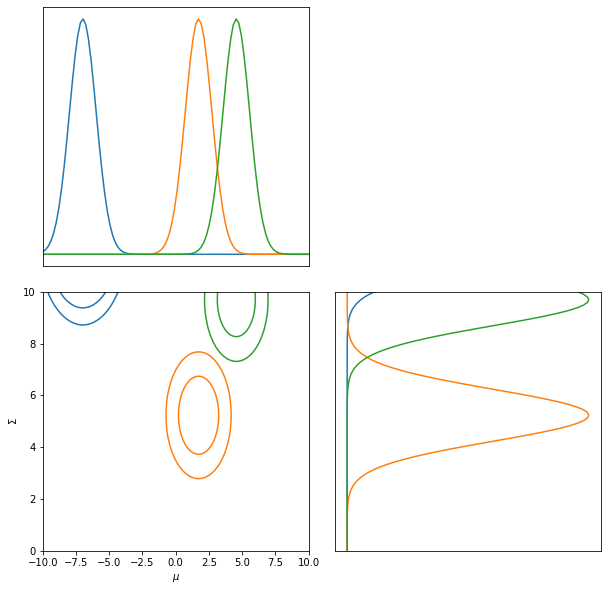

In [36]:
gradient_no_validation_ga.marginal_plot(labels=[r"$\mu$", r"$\Sigma$"]);

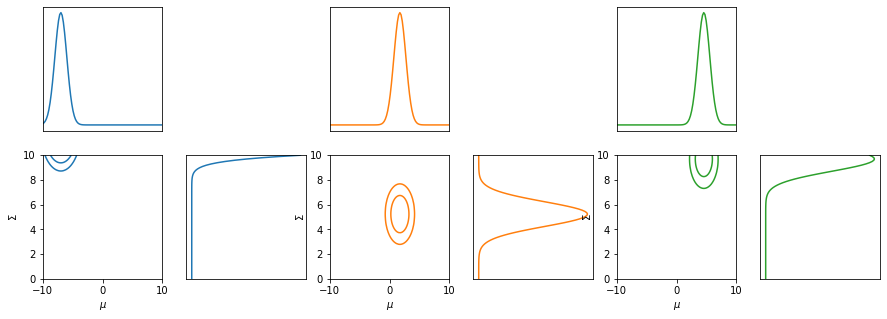

In [37]:
fig, ax = plt.subplots(2, 6, figsize=(15, 5))
gradient_no_validation_ga.marginal_plot(ax=ax[:, :2], labels=[r"$\mu$", r"$\Sigma$"], target=0, format=True);
gradient_no_validation_ga.marginal_plot(ax=ax[:, 2:4], labels=[r"$\mu$", r"$\Sigma$"], target=1, format=True);
gradient_no_validation_ga.marginal_plot(ax=ax[:, 4:], labels=[r"$\mu$", r"$\Sigma$"], target=2, format=True);

In [38]:
gradient_no_validation_abc = ApproximateBayesianComputation(target_data, prior, simulator, gradient_no_validation_imnn.get_estimate, F=gradient_no_validation_imnn.F, gridsize=50)

In [39]:
gradient_no_validation_abc(rng=abc_key, n_samples=int(1e6), min_accepted=1000, max_iterations=1000, ϵ=0.1, smoothing=1);

1005 accepted in last 21 iterations  (21000000 simulations done). 


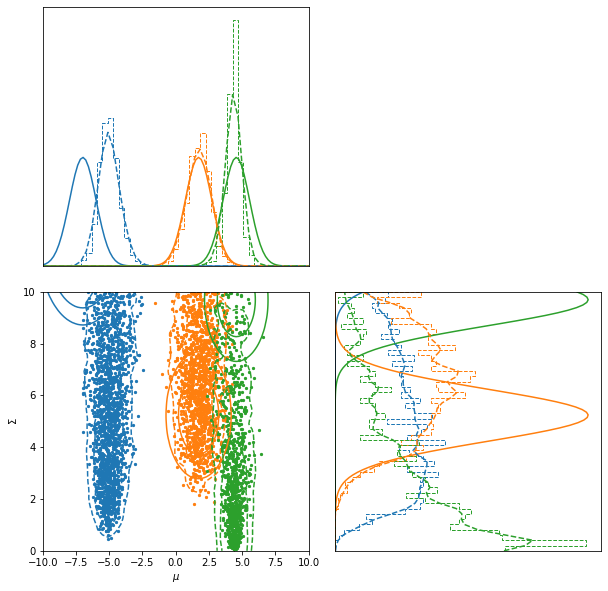

In [40]:
ax = gradient_no_validation_ga.marginal_plot(labels=[r"$\mu$", r"$\Sigma$"])
gradient_no_validation_abc.marginal_plot(ax=ax, linestyle="dashed")
gradient_no_validation_abc.scatter_plot(ax=ax, linestyle="dashed");

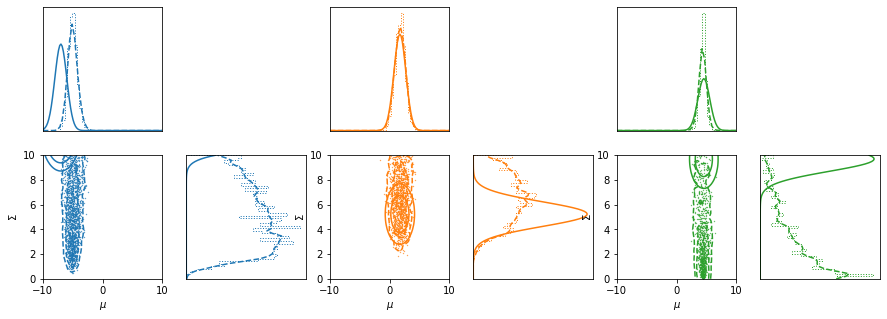

In [41]:
fig, ax = plt.subplots(2, 6, figsize=(15, 5))
gradient_no_validation_ga.marginal_plot(ax=ax[:, :2], labels=[r"$\mu$", r"$\Sigma$"], target=0, format=True);
gradient_no_validation_abc.marginal_plot(ax=ax[:, :2], linestyle="dashed", target=0);
gradient_no_validation_abc.scatter_plot(ax=ax[:, :2], linestyle="dotted", target=0, s=0.1);
gradient_no_validation_ga.marginal_plot(ax=ax[:, 2:4], labels=[r"$\mu$", r"$\Sigma$"], target=1, format=True);
gradient_no_validation_abc.marginal_plot(ax=ax[:, 2:4], linestyle="dashed", target=1);
gradient_no_validation_abc.scatter_plot(ax=ax[:, 2:4], linestyle="dotted", target=1, s=0.1);
gradient_no_validation_ga.marginal_plot(ax=ax[:, 4:], labels=[r"$\mu$", r"$\Sigma$"], target=2, format=True);
gradient_no_validation_abc.marginal_plot(ax=ax[:, 4:], linestyle="dashed", target=2);
gradient_no_validation_abc.scatter_plot(ax=ax[:, 4:], linestyle="dotted", target=2, s=0.1);

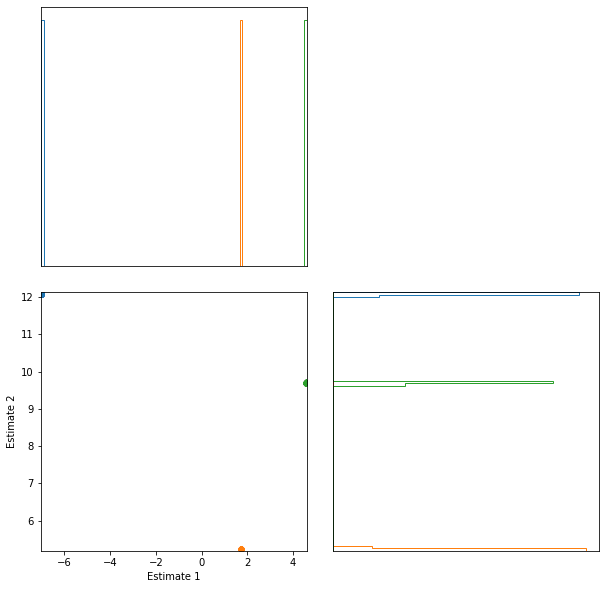

In [42]:
gradient_no_validation_abc.scatter_summaries(labels=["Estimate 1", "Estimate 2"]);

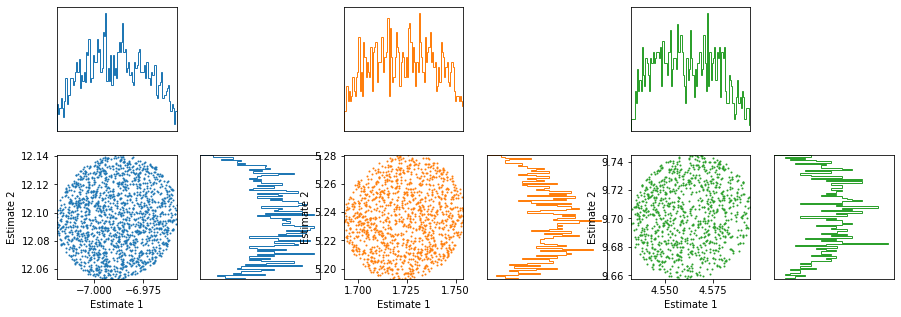

In [43]:
fig, ax = plt.subplots(2, 6, figsize=(15, 5))
gradient_no_validation_abc.scatter_summaries(ax=ax[:, :2], labels=["Estimate 1", "Estimate 2"], s=1, target=0, format=True);
gradient_no_validation_abc.scatter_summaries(ax=ax[:, 2:4], labels=["Estimate 1", "Estimate 2"], s=1, target=1, format=True);
gradient_no_validation_abc.scatter_summaries(ax=ax[:, 4:], labels=["Estimate 1", "Estimate 2"], s=1, target=2, format=True);

### With validation

In [44]:
rng, *validation_keys = jax.random.split(rng, num=1+n_s)

In [45]:
validation_fiducial, validation_derivative = jax.vmap(partial(simulator_gradient, θ=θ_fid, simulator_args=simulator_args))(np.array(validation_keys))
validation_fiducial.shape, validation_derivative.shape

((1000, 10), (1000, 10, 2))

In [46]:
gradient_imnn = GradientIMNN(n_s=n_s, n_d=n_d, n_summaries=n_summaries, input_shape=input_shape, 
                             θ_fid=θ_fid, key=initial_model_key, model=model, optimiser=optimiser, 
                             fiducial=fiducial, derivative=derivative,
                             validation_fiducial=validation_fiducial,
                             validation_derivative=validation_derivative)

In [47]:
gradient_imnn.fit(λ=λ, α=α, rng=fitting_key)

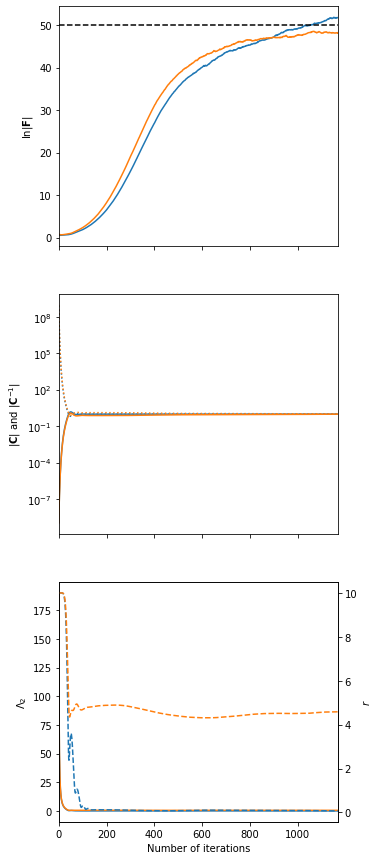

In [48]:
gradient_imnn.training_plot(expected_detF=50);

#### ABC

In [49]:
gradient_target_summaries = gradient_imnn.get_estimate(target_data)

In [50]:
gradient_ga = GaussianApproximation(gradient_target_summaries, gradient_imnn.invC, prior)

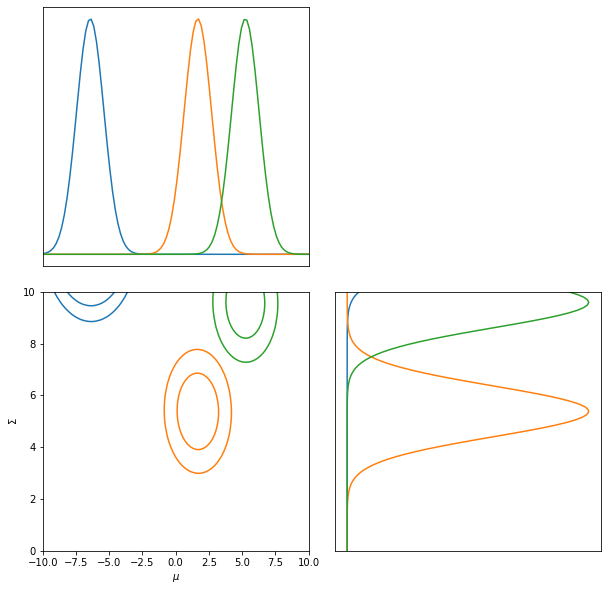

In [51]:
gradient_ga.marginal_plot(labels=[r"$\mu$", r"$\Sigma$"]);

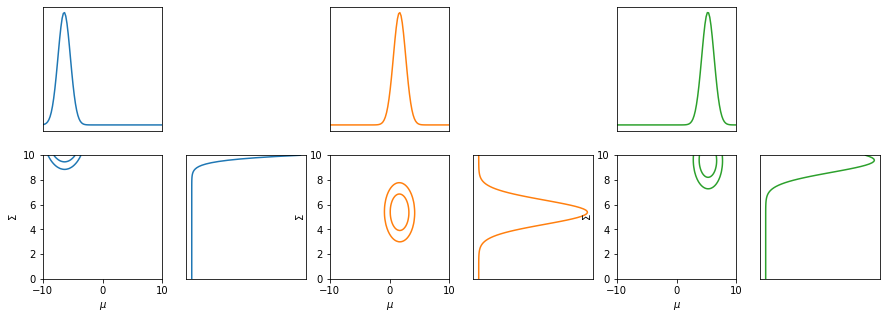

In [52]:
fig, ax = plt.subplots(2, 6, figsize=(15, 5))
gradient_ga.marginal_plot(ax=ax[:, :2], labels=[r"$\mu$", r"$\Sigma$"], target=0, format=True);
gradient_ga.marginal_plot(ax=ax[:, 2:4], labels=[r"$\mu$", r"$\Sigma$"], target=1, format=True);
gradient_ga.marginal_plot(ax=ax[:, 4:], labels=[r"$\mu$", r"$\Sigma$"], target=2, format=True);

In [53]:
gradient_abc = ApproximateBayesianComputation(target_data, prior, simulator, gradient_imnn.get_estimate, F=gradient_imnn.F, gridsize=50)

In [54]:
gradient_abc(rng=abc_key, n_samples=int(1e6), min_accepted=1000, max_iterations=1000, ϵ=0.1, smoothing=1);

1002 accepted in last 43 iterations  (43000000 simulations done). 


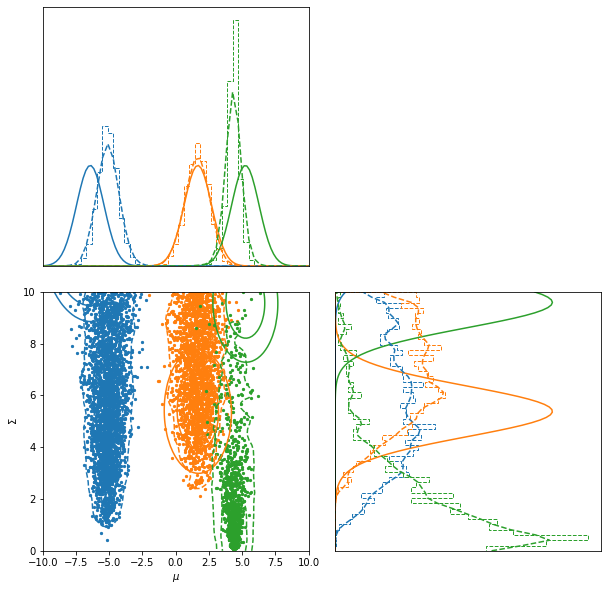

In [55]:
ax = gradient_ga.marginal_plot(labels=[r"$\mu$", r"$\Sigma$"])
gradient_abc.marginal_plot(ax=ax, linestyle="dashed")
gradient_abc.scatter_plot(ax=ax, linestyle="dashed");

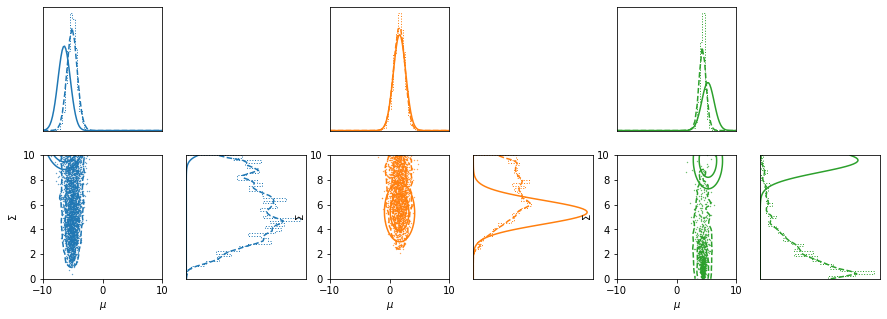

In [56]:
fig, ax = plt.subplots(2, 6, figsize=(15, 5))
gradient_ga.marginal_plot(ax=ax[:, :2], labels=[r"$\mu$", r"$\Sigma$"], target=0, format=True);
gradient_abc.marginal_plot(ax=ax[:, :2], linestyle="dashed", target=0);
gradient_abc.scatter_plot(ax=ax[:, :2], linestyle="dotted", target=0, s=0.1);
gradient_ga.marginal_plot(ax=ax[:, 2:4], labels=[r"$\mu$", r"$\Sigma$"], target=1, format=True);
gradient_abc.marginal_plot(ax=ax[:, 2:4], linestyle="dashed", target=1);
gradient_abc.scatter_plot(ax=ax[:, 2:4], linestyle="dotted", target=1, s=0.1);
gradient_ga.marginal_plot(ax=ax[:, 4:], labels=[r"$\mu$", r"$\Sigma$"], target=2, format=True);
gradient_abc.marginal_plot(ax=ax[:, 4:], linestyle="dashed", target=2);
gradient_abc.scatter_plot(ax=ax[:, 4:], linestyle="dotted", target=2, s=0.1);

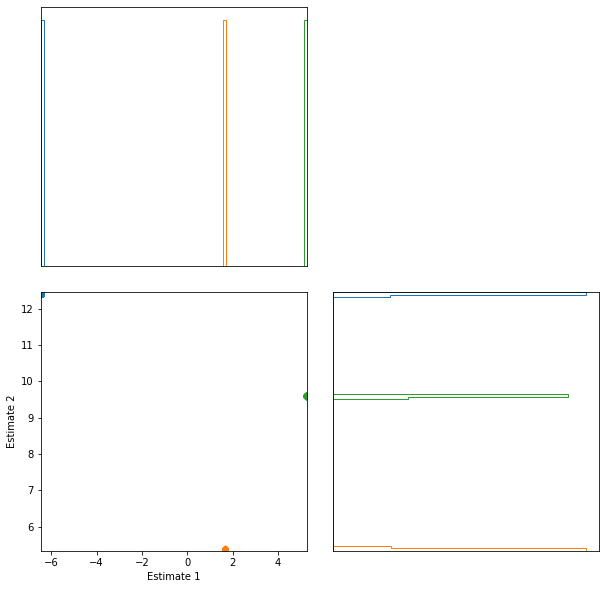

In [57]:
gradient_abc.scatter_summaries(labels=["Estimate 1", "Estimate 2"]);

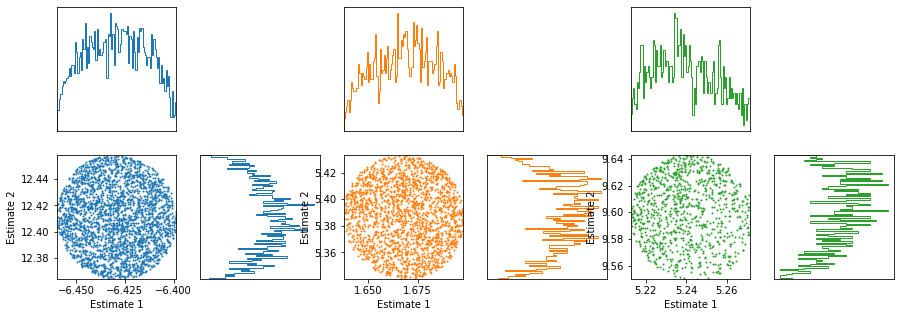

In [58]:
fig, ax = plt.subplots(2, 6, figsize=(15, 5))
gradient_abc.scatter_summaries(ax=ax[:, :2], labels=["Estimate 1", "Estimate 2"], s=1, target=0, format=True);
gradient_abc.scatter_summaries(ax=ax[:, 2:4], labels=["Estimate 1", "Estimate 2"], s=1, target=1, format=True);
gradient_abc.scatter_summaries(ax=ax[:, 4:], labels=["Estimate 1", "Estimate 2"], s=1, target=2, format=True);

# Precomputed simulations with numerical gradients

In [59]:
δθ = np.array([0.1, 0.1])

In [60]:
numerical_derivative = np.stack([
    np.stack([
        jax.vmap(partial(simulator, θ=(θ_fid[0]-δθ[0]/2., θ_fid[1]), simulator_args=simulator_args))(np.array(training_keys)),
        jax.vmap(partial(simulator, θ=(θ_fid[0], θ_fid[1]-δθ[1]/2.), simulator_args=simulator_args))(np.array(training_keys))],
        1),
    np.stack([
        jax.vmap(partial(simulator, θ=(θ_fid[0]+δθ[0]/2., θ_fid[1]), simulator_args=simulator_args))(np.array(training_keys)),
        jax.vmap(partial(simulator, θ=(θ_fid[0], θ_fid[1]+δθ[1]/2.), simulator_args=simulator_args))(np.array(training_keys))],
        1)], 
    1)
numerical_derivative.shape

(1000, 2, 2, 10)

In [61]:
numerical_gradient_no_validation_imnn = NumericalGradientIMNN(n_s=n_s, n_d=n_d, n_summaries=n_summaries, input_shape=input_shape, 
                                        θ_fid=θ_fid, key=initial_model_key, model=model, optimiser=optimiser, δθ=δθ,
                                        fiducial=fiducial, derivative=numerical_derivative)

In [62]:
numerical_gradient_no_validation_imnn.fit(λ=λ, α=α, rng=fitting_key)

no available validation data. setting statistics with training set


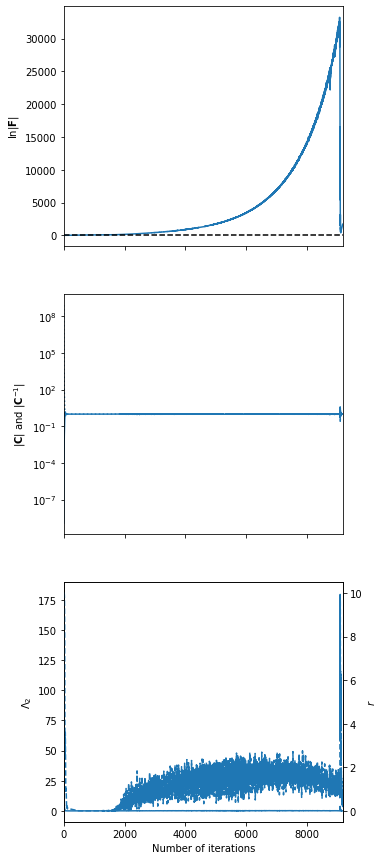

In [63]:
numerical_gradient_no_validation_imnn.training_plot(expected_detF=50);

#### ABC

In [64]:
numerical_gradient_no_validation_target_summaries = numerical_gradient_no_validation_imnn.get_estimate(target_data)

In [65]:
numerical_gradient_no_validation_ga = GaussianApproximation(numerical_gradient_no_validation_target_summaries, numerical_gradient_no_validation_imnn.invC, prior)

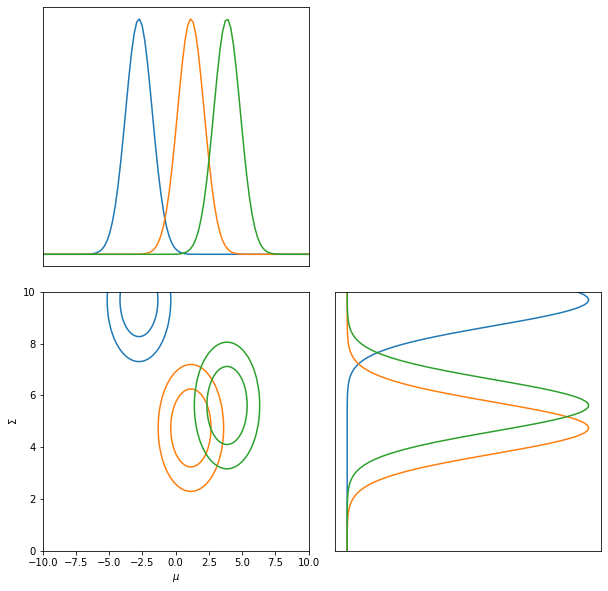

In [66]:
numerical_gradient_no_validation_ga.marginal_plot(labels=[r"$\mu$", r"$\Sigma$"]);

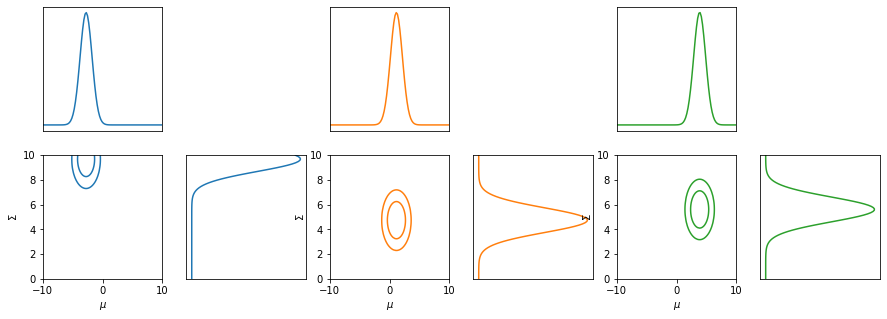

In [67]:
fig, ax = plt.subplots(2, 6, figsize=(15, 5))
numerical_gradient_no_validation_ga.marginal_plot(ax=ax[:, :2], labels=[r"$\mu$", r"$\Sigma$"], target=0, format=True);
numerical_gradient_no_validation_ga.marginal_plot(ax=ax[:, 2:4], labels=[r"$\mu$", r"$\Sigma$"], target=1, format=True);
numerical_gradient_no_validation_ga.marginal_plot(ax=ax[:, 4:], labels=[r"$\mu$", r"$\Sigma$"], target=2, format=True);

In [68]:
numerical_gradient_no_validation_abc = ApproximateBayesianComputation(
    target_data, prior, simulator, numerical_gradient_no_validation_imnn.get_estimate, F=numerical_gradient_no_validation_imnn.F, gridsize=50)

In [69]:
numerical_gradient_no_validation_abc(rng=abc_key, n_samples=int(1e6), min_accepted=1000, max_iterations=100, ϵ=0.1, smoothing=1);

66 accepted in last 100 iterations  (100000000 simulations done). 


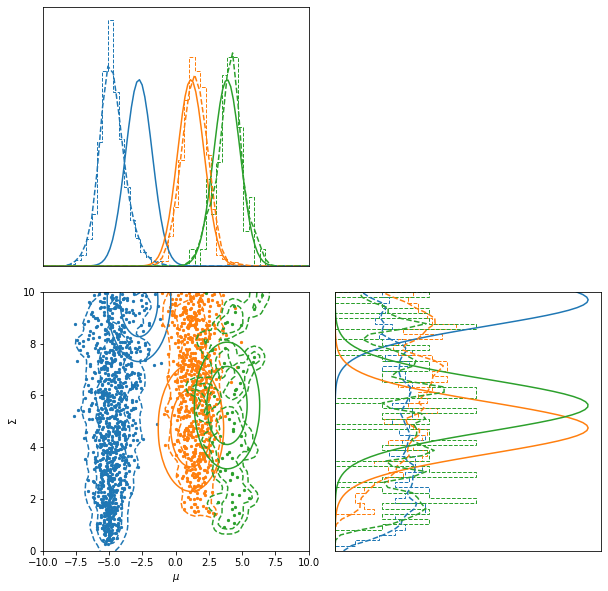

In [70]:
ax = numerical_gradient_no_validation_ga.marginal_plot(labels=[r"$\mu$", r"$\Sigma$"])
numerical_gradient_no_validation_abc.marginal_plot(ax=ax, linestyle="dashed")
numerical_gradient_no_validation_abc.scatter_plot(ax=ax, linestyle="dashed");

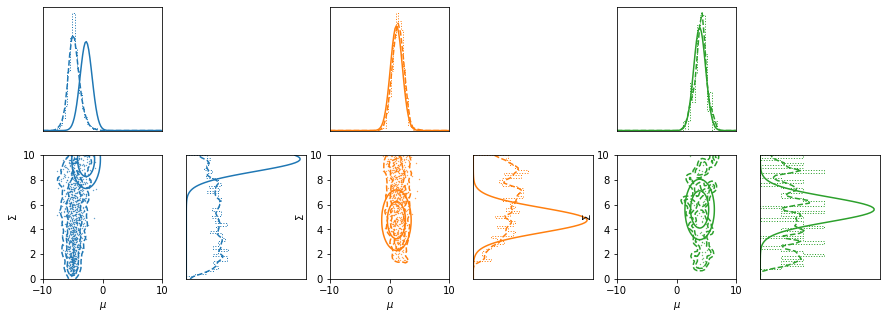

In [71]:
fig, ax = plt.subplots(2, 6, figsize=(15, 5))
numerical_gradient_no_validation_ga.marginal_plot(ax=ax[:, :2], labels=[r"$\mu$", r"$\Sigma$"], target=0, format=True);
numerical_gradient_no_validation_abc.marginal_plot(ax=ax[:, :2], linestyle="dashed", target=0);
numerical_gradient_no_validation_abc.scatter_plot(ax=ax[:, :2], linestyle="dotted", target=0, s=0.1);
numerical_gradient_no_validation_ga.marginal_plot(ax=ax[:, 2:4], labels=[r"$\mu$", r"$\Sigma$"], target=1, format=True);
numerical_gradient_no_validation_abc.marginal_plot(ax=ax[:, 2:4], linestyle="dashed", target=1);
numerical_gradient_no_validation_abc.scatter_plot(ax=ax[:, 2:4], linestyle="dotted", target=1, s=0.1);
numerical_gradient_no_validation_ga.marginal_plot(ax=ax[:, 4:], labels=[r"$\mu$", r"$\Sigma$"], target=2, format=True);
numerical_gradient_no_validation_abc.marginal_plot(ax=ax[:, 4:], linestyle="dashed", target=2);
numerical_gradient_no_validation_abc.scatter_plot(ax=ax[:, 4:], linestyle="dotted", target=2, s=0.1);

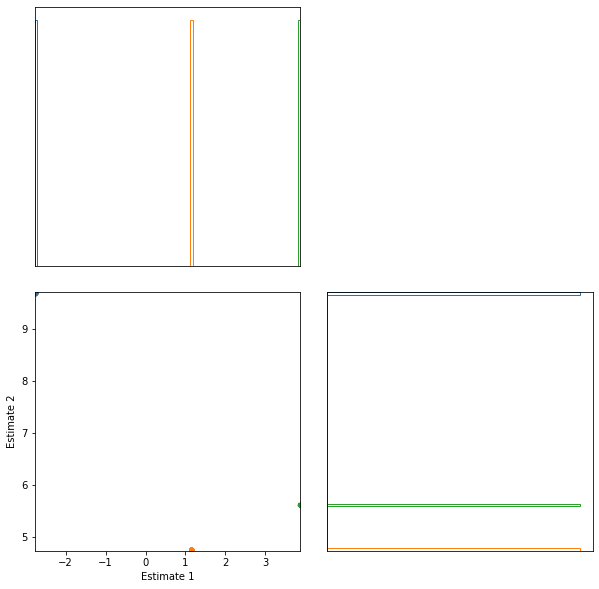

In [72]:
numerical_gradient_no_validation_abc.scatter_summaries(labels=["Estimate 1", "Estimate 2"]);

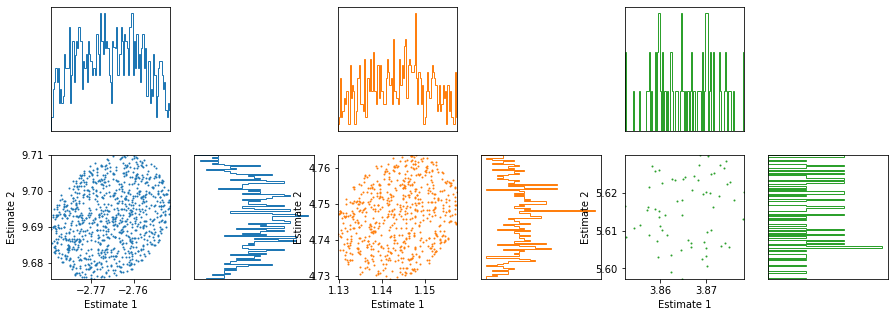

In [73]:
fig, ax = plt.subplots(2, 6, figsize=(15, 5))
numerical_gradient_no_validation_abc.scatter_summaries(ax=ax[:, :2], labels=["Estimate 1", "Estimate 2"], s=1, target=0, format=True);
numerical_gradient_no_validation_abc.scatter_summaries(ax=ax[:, 2:4], labels=["Estimate 1", "Estimate 2"], s=1, target=1, format=True);
numerical_gradient_no_validation_abc.scatter_summaries(ax=ax[:, 4:], labels=["Estimate 1", "Estimate 2"], s=1, target=2, format=True);

### With validation

In [74]:
validation_numerical_derivative = np.stack([
    np.stack([
        jax.vmap(partial(simulator, θ=(θ_fid[0]-δθ[0]/2., θ_fid[1]), simulator_args=simulator_args))(np.array(validation_keys)),
        jax.vmap(partial(simulator, θ=(θ_fid[0], θ_fid[1]-δθ[1]/2.), simulator_args=simulator_args))(np.array(validation_keys))],
        1),
    np.stack([
        jax.vmap(partial(simulator, θ=(θ_fid[0]+δθ[0]/2., θ_fid[1]), simulator_args=simulator_args))(np.array(validation_keys)),
        jax.vmap(partial(simulator, θ=(θ_fid[0], θ_fid[1]+δθ[1]/2.), simulator_args=simulator_args))(np.array(validation_keys))],
        1)], 
    1)
validation_numerical_derivative.shape

(1000, 2, 2, 10)

In [78]:
numerical_gradient_imnn = NumericalGradientIMNN(n_s=n_s, n_d=n_d, n_summaries=n_summaries, input_shape=input_shape, 
                             θ_fid=θ_fid, key=initial_model_key, model=model, optimiser=optimiser, 
                             fiducial=fiducial, derivative=numerical_derivative, δθ=δθ,
                             validation_fiducial=validation_fiducial,
                             validation_derivative=validation_numerical_derivative)

In [79]:
numerical_gradient_imnn.fit(λ=λ, α=α, rng=fitting_key)

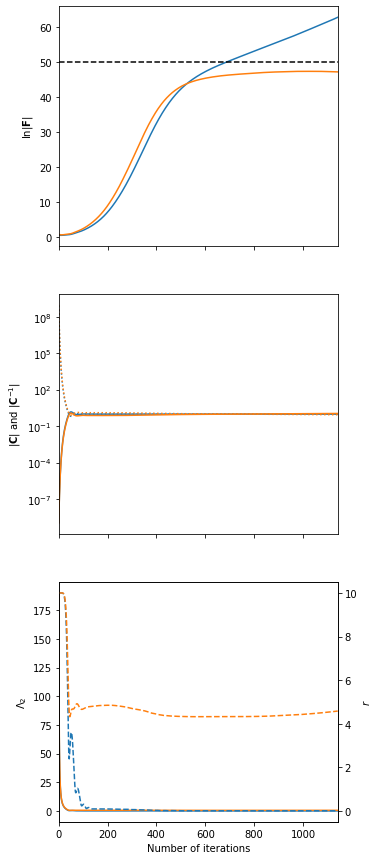

In [80]:
numerical_gradient_imnn.training_plot(expected_detF=50);

#### ABC

In [81]:
numerical_gradient_target_summaries = numerical_gradient_imnn.get_estimate(target_data)

In [82]:
numerical_gradient_ga = GaussianApproximation(numerical_gradient_target_summaries, numerical_gradient_imnn.invC, prior)

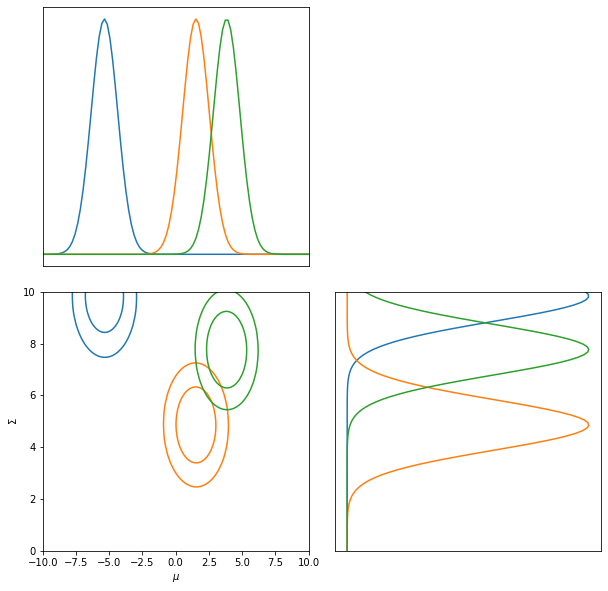

In [83]:
numerical_gradient_ga.marginal_plot(labels=[r"$\mu$", r"$\Sigma$"]);

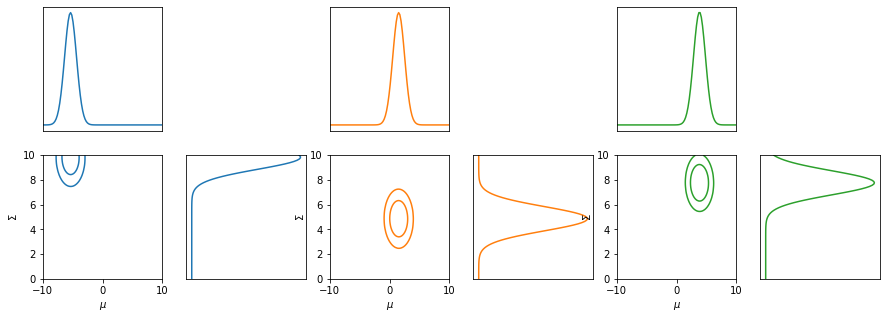

In [84]:
fig, ax = plt.subplots(2, 6, figsize=(15, 5))
numerical_gradient_ga.marginal_plot(ax=ax[:, :2], labels=[r"$\mu$", r"$\Sigma$"], target=0, format=True);
numerical_gradient_ga.marginal_plot(ax=ax[:, 2:4], labels=[r"$\mu$", r"$\Sigma$"], target=1, format=True);
numerical_gradient_ga.marginal_plot(ax=ax[:, 4:], labels=[r"$\mu$", r"$\Sigma$"], target=2, format=True);

In [85]:
numerical_gradient_abc = ApproximateBayesianComputation(target_data, prior, simulator, gradient_imnn.get_estimate, F=gradient_imnn.F, gridsize=50)

In [86]:
numerical_gradient_abc(rng=abc_key, n_samples=int(1e6), min_accepted=1000, max_iterations=1000, ϵ=0.1, smoothing=1);

1002 accepted in last 43 iterations  (43000000 simulations done). 


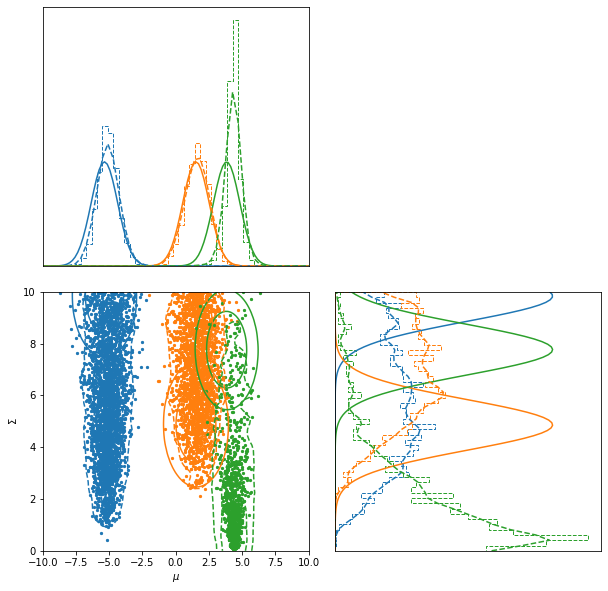

In [87]:
ax = numerical_gradient_ga.marginal_plot(labels=[r"$\mu$", r"$\Sigma$"])
numerical_gradient_abc.marginal_plot(ax=ax, linestyle="dashed")
numerical_gradient_abc.scatter_plot(ax=ax, linestyle="dashed");

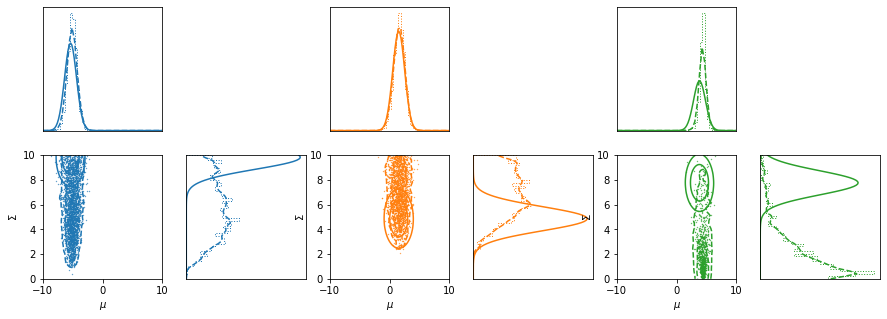

In [88]:
fig, ax = plt.subplots(2, 6, figsize=(15, 5))
numerical_gradient_ga.marginal_plot(ax=ax[:, :2], labels=[r"$\mu$", r"$\Sigma$"], target=0, format=True);
numerical_gradient_abc.marginal_plot(ax=ax[:, :2], linestyle="dashed", target=0);
numerical_gradient_abc.scatter_plot(ax=ax[:, :2], linestyle="dotted", target=0, s=0.1);
numerical_gradient_ga.marginal_plot(ax=ax[:, 2:4], labels=[r"$\mu$", r"$\Sigma$"], target=1, format=True);
numerical_gradient_abc.marginal_plot(ax=ax[:, 2:4], linestyle="dashed", target=1);
numerical_gradient_abc.scatter_plot(ax=ax[:, 2:4], linestyle="dotted", target=1, s=0.1);
numerical_gradient_ga.marginal_plot(ax=ax[:, 4:], labels=[r"$\mu$", r"$\Sigma$"], target=2, format=True);
numerical_gradient_abc.marginal_plot(ax=ax[:, 4:], linestyle="dashed", target=2);
numerical_gradient_abc.scatter_plot(ax=ax[:, 4:], linestyle="dotted", target=2, s=0.1);

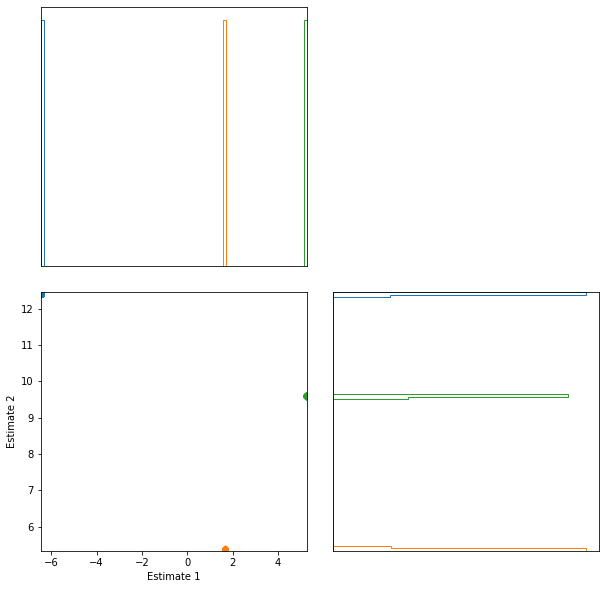

In [89]:
numerical_gradient_abc.scatter_summaries(labels=["Estimate 1", "Estimate 2"]);

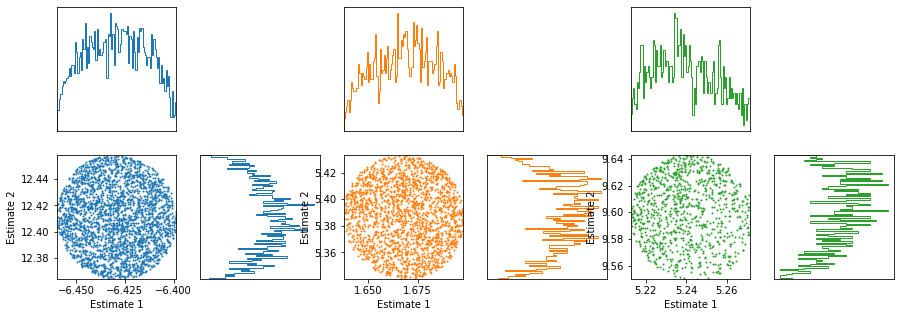

In [90]:
fig, ax = plt.subplots(2, 6, figsize=(15, 5))
numerical_gradient_abc.scatter_summaries(ax=ax[:, :2], labels=["Estimate 1", "Estimate 2"], s=1, target=0, format=True);
numerical_gradient_abc.scatter_summaries(ax=ax[:, 2:4], labels=["Estimate 1", "Estimate 2"], s=1, target=1, format=True);
numerical_gradient_abc.scatter_summaries(ax=ax[:, 4:], labels=["Estimate 1", "Estimate 2"], s=1, target=2, format=True);